<a href="https://colab.research.google.com/github/VJsai45/Street-View-Image-Segmentation/blob/main/UNET_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


from IPython.display import clear_output

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git  
!pip install -U tfds-nightly

In [ ]:

data_dir = tf.keras.utils.get_file(origin='https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz',
                                         fname='/content/CompressedData.tar.gz', extract=True,archive_format='tar')
data_dir = pathlib.Path(data_dir)

598917120/598913237 [==============================] - 20s 0us/step


In [ ]:
import tarfile
tar = tarfile.open("/content/CompressedData.tar.gz")
tar.extractall()
tar.close()


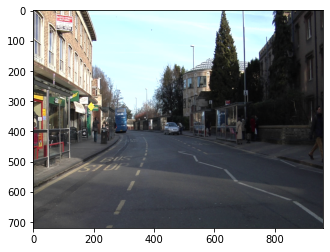

In [ ]:
from PIL import Image
im1 = Image.open("/content/camvid/labels/0001TP_006690_P.png") 

plt.imshow(im1);
path1 = "/content/camvid/images/0016E5_08580.png"
im2 = Image.open(path1) 
plt.imshow(im2);
img = tf.io.read_file(path1)
img = tf.image.decode_png(img)


In [ ]:
path2 = "/content/camvid/labels/0016E5_08580_P.png"
label = tf.io.read_file(path2)
label = tf.image.decode_png(label)

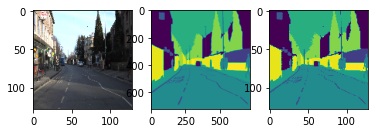

In [ ]:
# import pandas as p
# df = pd.DataFrame(tf.constant(im))
# df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')
# tf.image.convert_image_dtype(im,dtype=tf.float16,saturate=False)
# img.numpy()
imgdata = tf.image.resize(img,(128,128))
labeldata1 = tf.image.resize(label,(720,720))
labeldata2 = tf.image.resize(label,(128,128))
imgdata = imgdata/255.0
labeldata1 = labeldata1.numpy().reshape(720,720)
labeldata2 = labeldata2.numpy().reshape(128,128)
plt.subplot(1,3,1)
plt.imshow(imgdata)
plt.subplot(1,3,2)
plt.imshow(labeldata1)
plt.subplot(1,3,3)
plt.imshow(labeldata2)

In [ ]:
# Convert image from file path to tensor
def convert_image_to_tensor(file_path):
  # print(tf.strings.split(file_path, os.path.sep)[-1])
  img = tf.io.read_file(file_path)
  img = tf.image.decode_png(img)
  img = tf.image.resize(img,(128,128))
  label = label_func(file_path)
  label = tf.io.read_file(label)
  label = tf.image.decode_png(label)
  label = tf.image.resize(label,(128,128))
  img = img/255.0
  return img, label

In [ ]:
path = pathlib.Path("/content/camvid/")
image_paths = pathlib.Path("/content/camvid/images")
image_paths = list(image_paths.glob('*.png'))
label_paths = []

In [ ]:
def label_func(file_path):
  fn = tf.strings.split(file_path, os.path.sep)[-1]
  fn = tf.strings.split(fn,".")[0]
  fn = tf.strings.join(["/content/camvid/labels/",fn,"_P.png"])
  return fn

In [ ]:
# str(image_paths[10]).split("/")[-1]
image_paths[10]

PosixPath('/content/camvid/images/0016E5_05880.png')

In [ ]:
image_dataset = tf.data.Dataset.list_files("/content/camvid/images/*")
labeled_ds = image_dataset.map(convert_image_to_tensor, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# for f in image_dataset.take(5):
#   print(f.numpy())

(128, 128, 3)


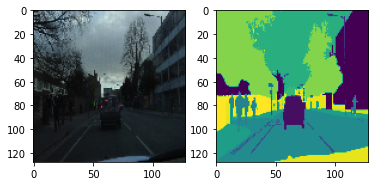

In [ ]:
for image, label in labeled_ds.take(1):
  plt.subplot(1,2,1)
  plt.imshow(image.numpy())
  plt.subplot(1,2,2)
  plt.imshow(label.numpy().reshape(128,128))
  print(image.shape)

In [ ]:
# Define left side of UNET i.e the conolutional network which downsamples the images
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False


In [ ]:
base_model.summary()

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(32)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

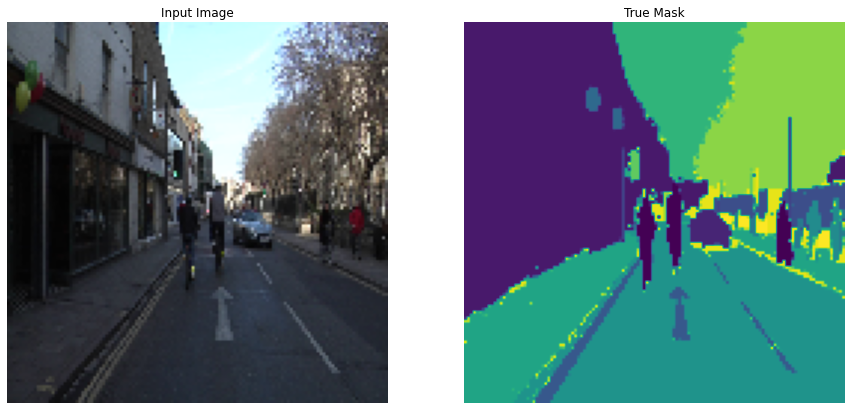

In [ ]:
for image, mask in labeled_ds.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in labeled_ds.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

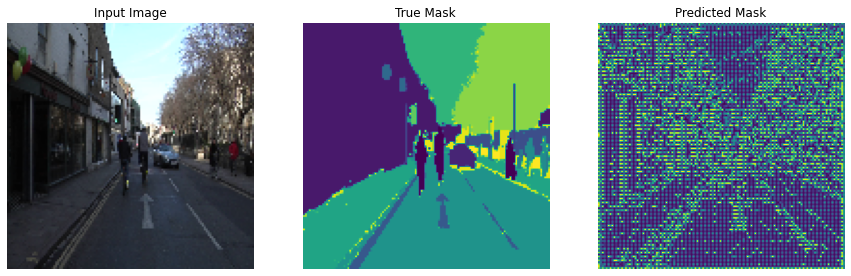

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 20
BATCH_SIZE = 10
BUFFER_SIZE = 701
STEPS_PER_EPOCH = 701 // BATCH_SIZE

STEPS_PER_EPOCH

70

In [ ]:
train_dataset = labeled_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:

model_history = model.from_configit(train_dataset, epochs=20,steps_per_epoch=STEPS_PER_EPOCH,callbacks=[DisplayCallback()])


In [ ]:
def segment_image_file(imagefilename,image_model):
  img = tf.io.read_file(imagefilename)
  img = tf.image.decode_jpeg(img)
  img = tf.image.resize(img,(128,128))
  img = img/255.0
  pred = image_model.predict(tf.reshape(img,[1,128,128,3]))

  pred = create_mask(pred)
  pred = pred.numpy().reshape(128,128)
  print(np.unique(pred))
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.subplot(1,2,2)
  plt.imshow(pred)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

model_name = 'MLDL_Image_Segmentation_mark_1'
path = F"/content/gdrive/My Drive/"+model_name
#model.save(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
saved_model = tf.keras.models.load_model(path)
segment_image_file("/content/tst3.jpg",saved_model)

### Javascript code for capturing webcam stream


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button'); // make button
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      //await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      // stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  # with open(filename, 'wb') as f:
  #   f.write(binary)
  # return filename
  return binary

### Segment the captured image 


In [ ]:
from io import BytesIO
def bytes_to_image_tensor(byte_data):
  image = Image.open(BytesIO(byte_data)).convert("RGB")
  image = tf.keras.preprocessing.image.img_to_array(image)
  # print(image.shape)
  image = image/255.0
  image = tf.convert_to_tensor(image,dtype=float)
  return image

In [ ]:
def segment_image_webcam():
  img  = bytes_to_image_tensor(take_photo())
  img = tf.image.resize(img,(128,128))
  pred = model.predict(tf.reshape(img,[1,128,128,3]))
  pred = create_mask(pred)
  pred = pred.numpy().reshape(128,128)
  # print(np.unique(pred))
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.subplot(1,2,2)
  plt.imshow(pred)

In [ ]:
for i in range(0,5):
  clear_output(wait=True)
  segment_image_webcam()

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button'); // make button
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      //await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      image = canvas.toDataURL('image/jpeg', quality);
      google.colab.kernel.invokeFunction('notebook.segment_frame', [image], {});

      // stream.getVideoTracks()[0].stop();
      
      //return canvas.toDataURL('image/jpeg', quality);
       await new Promise(resolve => setTimeout(resolve, 3000));
       div.remove();
       stream.getVideoTracks()[0].stop();
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  #binary = b64decode(data.split(',')[1])
  # with open(filename, 'wb') as f:
  #   f.write(binary)
  # return filename
  #return binary

In [ ]:

def segment_frame(image):
  try:
    binary = b64decode(image.split(',')[1])
    image = bytes_to_image_tensor(binary)
    plt.imshow(image)
    # segment_image_file('/content/teststrt2.jpg')
  except Exception as e:
      print('fhgfgfjgfj',e)
      

In [ ]:
import google.colab.output as output
output.register_callback('notebook.segment_frame', segment_frame)

In [ ]:
take_photo()


<IPython.core.display.Javascript object>